# L02 - Introduction to FEniCS - Darcy


<img style="float: left;" src="fig/fenics_logo.png" width=200>


In this notebook will will intruce the concept of pressure driven flow in porous media, as described by Darcy's equation. You will learn how to: 
 - Solve for a Darcian pressure field 
 - Postprocess a velocity field for application to fluid flow in porous media
 

## Porous flow and Darcy's equation in steady state
[wiki] <img style="float: left;" src="fig/Darcy.png" width=400> 


### Mathematical formulation:

Darcy's law is an equation that describes the flow of a fluid through a porous medium. 
In the absence of gravitational forces, it provides a simple relationship between the flow rate through a porous medium and the pressure drop over a given distance. For homogeneous permeable medium with permeability ${\kappa}$ and fluid dynamic viscosity ${\mu}$, one we can derive: 

$$ q =  - \: \frac {\kappa} {\mu} \:  \nabla P \:\:\:\:\:\:\:\:\:\:\:\:  (1) $$ 

where $q$ is the fluid discharge per unit area (m/s) and $∇p$ is the fluid pressure gradient vector (Pa/m). The discharge flux is often referred to as the Darcy flux or Darcy velocity, and is a average quantity of the fluid front through the porous media, it is different from the local fluid velocity traveling through the pore network. The fluid velocity $v_f$ can be recovered by rescaling the Darcy flux $q$ by the porosity of the media $\phi$.

$$ v_f =  \frac {q} {\phi}  $$ 

As now, we have one equation for two unknowns (the Darcy flux and the pressure gradient). By using the mass balance equation of the fluid, one can derive an expression for the fluid pressure:

$$ \frac {\partial \: \phi\rho_f} {\partial t} = \nabla \cdot \rho_f v_f  $$ 

Which simplies for constant fluid density $\rho_f$ and constant porosity field $\phi$ to: 

$$ \nabla \cdot v_f =  0 \:\:\:\:\:\: or \:\:\:\:\:\: \nabla \cdot q =  0 \:\:\:\:\:\:\:\:\:\:\:\:  (2) $$ 



Using equation (1) in (2) gives:

$$ \nabla \cdot   ( - \: \frac {\kappa} {\mu} \:  \nabla P ) =  0 $$ 

We have derive a Poisson equation as an expression for the fluid pressure field. One can solve this equation given some boundary conditions.




### Mathematical formulation:

Darcy's law is an equation that describes the flow of a fluid through a porous medium. 
In the absence of gravitational forces, it provides a simple relationship between the flow rate through a porous medium and the pressure drop over a given distance. For homogeneous permeable medium with permeability ${\kappa}$ and fluid dynamic viscosity ${\mu}$, one we can derive: 

$$ q =  - \: \frac {\kappa} {\mu} \:  \nabla P \:\:\:\:\:\:\:\:\:\:\:\:  (1) $$ 

where $q$ is the fluid discharge per unit area (m/s) and $∇p$ is the fluid pressure gradient vector (Pa/m). The discharge flux is often referred to as the Darcy flux or Darcy velocity, and is a average quantity of the fluid front through the porous media, it is different from the local fluid velocity traveling through the pore network. The fluid velocity $v_f$ can be recovered by rescaling the Darcy flux $q$ by the porosity of the media $\phi$.

$$ v_f =  \frac {q} {\phi}  $$ 

As now, we have one equation for two unknowns (the Darcy flux and the pressure gradient). By using the mass balance equation of the fluid, one can derive an expression for the fluid pressure:

$$ \frac {\partial \: \phi\rho_f} {\partial t} = \nabla \cdot \rho_f v_f  $$ 

Which simplies for constant fluid density $\rho_f$ and constant porosity field $\phi$ to: 

$$ \nabla \cdot v_f =  0 \:\:\:\:\:\: or \:\:\:\:\:\: \nabla \cdot q =  0 \:\:\:\:\:\:\:\:\:\:\:\:  (2) $$ 



Using equation (1) in (2) gives:

$$ \nabla \cdot   ( - \: \frac {\kappa} {\mu} \:  \nabla P ) =  0 $$ 

We have derive a Poisson equation as an expression for the fluid pressure field. One can solve this equation given some boundary conditions.




## First, let's import the FEniCS library through the DOLFIN import

In [1]:
%matplotlib inline

# Import all the functions from DOLFIN (computational backend of the FEniCS project)
from dolfin import * 

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


## Discretizing the domain and space of functions
We can now use FEniCS to solve our problem. First, we discretize our domain by creating a mesh of $\Omega$. 

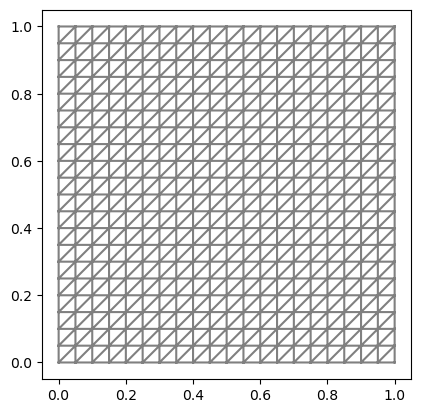

In [2]:
mesh = UnitSquareMesh(20,20) # 20 is number of intervals Omega is divided intoc
plot(mesh)

elem = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, elem)


## Specifying the weak formulation
Next, all we need to do is tell FEniCS the weak formulation of our problem.

In [3]:
kappa_over_mu = Constant(1.0) # physical material property
phi = Constant(0.1) # porosity, ranging from 0 to 1
S = Constant(0.0) # source term

V = TestFunction(W) # the test function
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown
U_old = Function(W) # Solution at previous time step. Initialized to zero.

a = kappa_over_mu * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
L = S * V * dx # right hand side of our equation

## Set the boundary conditions
Next, all we need to do is tell FEniCS the weak formulation of our problem.

In [4]:
value_left = Constant(1.0)
value_right = Constant(0.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

## Solve for the pressure field

Solving linear variational problem.


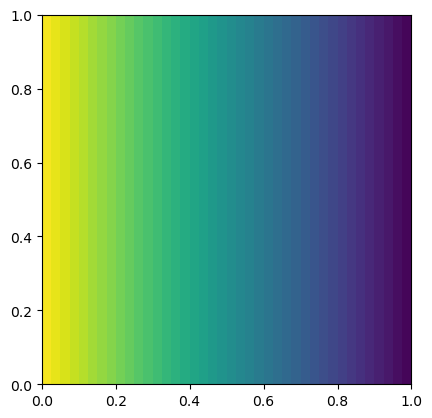

In [5]:
p_sol = Function(W)  # place to store the solution
solve(a == L, p_sol, bcs)
plot(p_sol);

## Estimate the velocity field from the pressure field (postprocessing)
In the previous tutorials, we have only worked with scalar quantities (such as concentration, pressure, temperature). However, as we would like to get the velocity field
$$ v_f =  \frac {q} {\phi}  $$ 
we need to define a suitable finite element space for this quantity.

As `$\phi$` is a first order Lagrange function, it's deriviative is a cell-wise continuous function (as explained in [Lecture 1](./L01_FEM_intro.ipynb)).
Thus, we create a vector-element, which will have the same number of dimensions as the mesh (1 in 1D, 2 in 2D, 3 in 3D).

In [6]:
elem_v = VectorElement("DG", triangle, 0) # This is new type of element (for vector field discretization)
W_v = FunctionSpace(mesh, elem_v)

Next, we need to compute $v_f$. We do this by a projection, which means solving the linear problem:
Find $v_f\in W_v$ such that
$$
\int_\Omega (v_f - \frac{q}{\phi})v~\mathrm{d}x = 0\qquad\forall v\in W_v
$$
There are several ways of computing this projection. The simplest (but most expensive if we need to do it multiple times) is to use the `project` function in FEniCS.

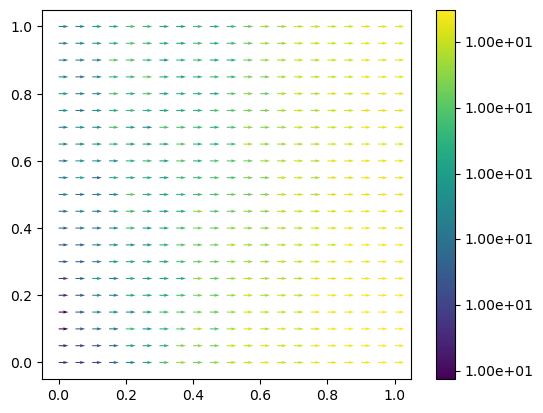

In [7]:
vel_f = project(-kappa_over_mu * grad(p_sol) / phi, W_v) 
import matplotlib.pyplot as plt
fig = plt.figure()
im = plot(vel_f)
plt.colorbar(im, format="%.2e");

## Paraview
We can output the solutions to [Paraview](https://www.paraview.org/) for post-processing.
We do this by using the `xdmf`-format, as shown below

In [8]:
with XDMFFile("Darcy_solutions.xdmf") as xdmf:
    xdmf.write(vel_f, 0.0)
    xdmf.write(p_sol, 0.0)

### Advanced: Reusable projection
As mentioned above, a projection is solve the problem
$$
a(u, v) = l(v)
$$
where
$$
a(u,v)=\int_\Omega u\cdot v~\mathrm{d}x
$$,
$$l(v)=\int_\Omega f\cdot v~\mathrm{d}x$$

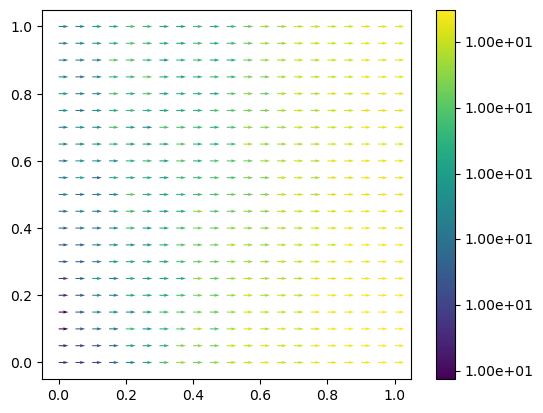

In [9]:
class Projector():
    def __init__(self, V):
        u = TrialFunction(V)
        v = TestFunction(V)
        a = inner(u, v) * dx
        self.A = assemble(a)
        self.u = Function(V)
        self.solver = LUSolver(self.A)

    def __call__(self, f):
        v = TestFunction(self.u.function_space())
        b = assemble(inner(f, v)*dx)
        self.solver.solve(self.u.vector(), b)
        return self.u

projector = Projector(W_v)
vel_f = projector(-kappa_over_mu * grad(p_sol) / phi) 
import matplotlib.pyplot as plt
fig = plt.figure()
im = plot(vel_f)
plt.colorbar(im, format="%.2e")

### Advanced: Local projection

As we are using a discontinuous function space to represent the velocity the degrees of freedom in each cell is independent of the others. Therefore, we can create a projection function using a `LocalSolver`.

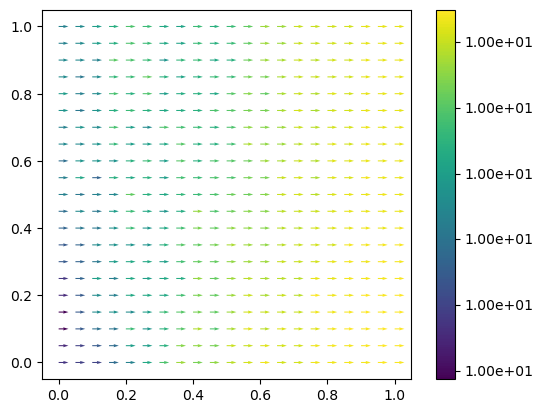

In [10]:
def local_project(f, V):
    u = TrialFunction(V)
    v = TestFunction(V)
    a_proj = inner(u, v)*dx
    b_proj = inner(f, v)*dx
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    u = Function(V)
    solver.solve_local_rhs(u)
    return u

vel_f = local_project(-kappa_over_mu * grad(p_sol) / phi, W_v) 
import matplotlib.pyplot as plt
fig = plt.figure()
im = plot(vel_f)
plt.colorbar(im, format="%.2e");